# Does it get warmer before it rains?

#### Apurva Raman and William Lu

Speculating about the weather has been a staple of small talk and human curiosity for a long time, and as a result, many weather "myths" exist. One such myth we’ve heard is that it gets warmer before a precipitation event (e.g. rain, snow, hail, sleet, etc.) occurs.

To see whether or not this conjecture has a basis in fact, we use historical climatological data for multiple cities from the US National Oceanic and Atmospheric Administration (NOAA) to see if there is a correlation between perceptible changes in temperature and precipitation events.


First, let's import data and necessary packages.

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot_date
import seaborn as sns

import datetime as dt
from datetime import datetime
from IPython.display import display

import thinkstats2
import thinkplot

import statsmodels.formula.api as smf

In [2]:
stations = {'Seattle': 'WBAN:24233', 
            'Boston': 'WBAN:14739', 
            'Lexington': 'WBAN:93820', 
            'San Diego': 'WBAN:93107'}

selected_station = 'Seattle'

# Make a date parsing function with the correct format
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

# Read the CSV while parsing the dates
df = pd.read_csv("913023.csv", parse_dates=['DATE'], date_parser=dateparse)

/home/william/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8,10,11,12,13,14,15,16,17,19,20,22,23,25,26,27,28,29,33,34,37,38,39,40,44,45,46,47,48,50,59,60,62,63,64,67,68,69,71,72,73,84,85,86,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Remove all columns except for STATION, DATE, DAILYAverageDryBulbTemp, DAILYPrecip
#Make a copy of the original DataFrame
seatac = df.copy(deep=True)

#Uses DATE column as row index for resampling purposes later
seatac.set_index('DATE', inplace=True)

#Select rows of data for Seattle (WBAN:24233)
seatac = seatac.loc[seatac['STATION'] == stations[selected_station]]

#Select columns with data we need
seatac = seatac[['STATION', 'DAILYAverageDryBulbTemp', 'DAILYPrecip']]

#Select 2015 data
seatac_2015 = seatac.copy(deep=True)
seatac_2015 = seatac_2015.ix['2015-01-01':'2015-12-31']

In [4]:
# Turn all non-numerical values into NaN for columns that should be numbers (via coerce) 
seatac_2015['DAILYAverageDryBulbTemp'] = seatac_2015['DAILYAverageDryBulbTemp'].apply(pd.to_numeric, errors='coerce')
seatac_2015['DAILYPrecip'] = seatac_2015['DAILYPrecip'].apply(pd.to_numeric, errors='coerce')

#Drop rows where there is no DAILYAverageDryBulbTemp value
seatac_2015.dropna(subset=['DAILYAverageDryBulbTemp'], inplace=True)

# Replace NaN for precipitation with 0
seatac_2015['DAILYPrecip'].fillna(0, inplace=True)

# Replace trace amounts of precipitation ('T') with 0.00001
seatac_2015['DAILYPrecip'].replace('T', 0.00001, inplace=True)

# Downsamples data to 1 day -- temperatures are averaged and precipitation is added
seatac_2015 = seatac_2015.resample('1D').agg({'DAILYAverageDryBulbTemp': np.mean, 'DAILYPrecip': np.sum})

# Fills in upsampled data that is NaN with data from previous day
seatac_2015.DAILYAverageDryBulbTemp.fillna(method='pad', limit=2,inplace=True)
seatac_2015.DAILYPrecip.fillna(method='pad', limit=2, inplace=True)

In order to figure out what people mean when they say that "it gets warmer," we try two different ways of quantifying a warming temperature trend. The first way we try is comparing the average temperature on any given day with the 3 day moving average of temperature for the previous day. The second way we try is taking the derivative of temperature on any given day.

In [5]:
# Takes the 3 day moving average of temperature
seatac_2015['MOVAvg'] = seatac_2015.rolling(window='3D', min_periods=1).mean()['DAILYAverageDryBulbTemp']

# Finds the slope of temperature change over three days
seatac_2015['SLOPETemp'] = np.gradient(seatac_2015.DAILYAverageDryBulbTemp)

# Calculates deviation from the moving average for the previous three days of temperature data
for d in seatac_2015.index:
    if d.month == 1 and d.day == 1:
        seatac_2015.loc[d, 'DEVFromAvg'] = 0
    else:
        seatac_2015.loc[d, 'DEVFromAvg'] = seatac_2015.loc[d, 'DAILYAverageDryBulbTemp'] - seatac_2015.loc[d-1, 'MOVAvg']

# Shift SLOPETemp column down 1 in order to reference the previous day's temperature slope
seatac_2015.SLOPETemp = seatac_2015.SLOPETemp.shift(1)
seatac_2015 = seatac_2015.ix[1:]

seatac_2015['ISRisingAvg'] = seatac_2015.DEVFromAvg > 3
seatac_2015['ISRisingSlp'] = seatac_2015.SLOPETemp > 0

display(seatac_2015)

,DAILYAverageDryBulbTemp,DAILYPrecip,MOVAvg,SLOPETemp,DEVFromAvg,ISRisingAvg,ISRisingSlp
DATE,,,,,,,
2015-01-02,36.750000,0.06,35.500000,2.500000,2.500000,False,True
2015-01-03,38.000000,0.06,36.333333,1.875000,2.500000,False,True
2015-01-04,43.000000,0.40,39.250000,3.125000,6.666667,True,True
2015-01-05,51.250000,0.70,44.083333,6.625000,12.000000,True,True
2015-01-06,48.750000,0.24,47.666667,2.875000,4.666667,True,True
2015-01-07,45.000000,0.00,48.333333,-3.125000,-2.666667,False,False
2015-01-08,40.750000,0.00,44.833333,-4.000000,-7.583333,False,False
2015-01-09,42.500000,0.01,42.750000,-1.250000,-2.333333,False,False
2015-01-10,44.500000,0.23,42.583333,1.875000,1.750000,False,True


In order to check if we have sufficient data to work with, we plot the scatterplot of temperature deviation over time, as calculated using a moving average.

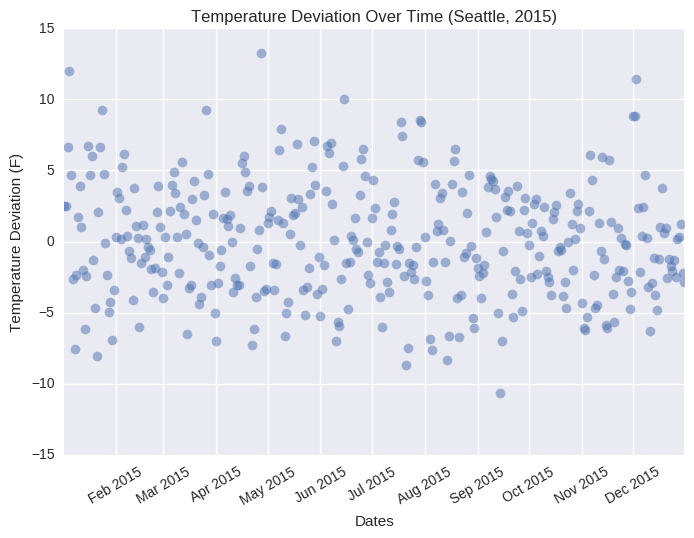

In [6]:
# Graph scatterplot of temperature deviations over time
temp_deviation = seatac_2015.copy(deep=True)
temp_deviation = temp_deviation['DEVFromAvg']

plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg, alpha=0.5)
plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (%s, 2015)' %(selected_station))
plt.show()

Now that we have temperature deviation, we begin to incorporate precipitation data.

In [7]:
# Evaluates whether or not precipitation occurred on a day
seatac_2015['BOOLPrecip'] = seatac_2015.DAILYPrecip > 0
seatac_2015['BOOLPrecipNum'] = seatac_2015['BOOLPrecip'].astype(int)

display(seatac_2015)

,DAILYAverageDryBulbTemp,DAILYPrecip,MOVAvg,SLOPETemp,DEVFromAvg,ISRisingAvg,ISRisingSlp,BOOLPrecip,BOOLPrecipNum
DATE,,,,,,,,,
2015-01-02,36.750000,0.06,35.500000,2.500000,2.500000,False,True,True,1
2015-01-03,38.000000,0.06,36.333333,1.875000,2.500000,False,True,True,1
2015-01-04,43.000000,0.40,39.250000,3.125000,6.666667,True,True,True,1
2015-01-05,51.250000,0.70,44.083333,6.625000,12.000000,True,True,True,1
2015-01-06,48.750000,0.24,47.666667,2.875000,4.666667,True,True,True,1
2015-01-07,45.000000,0.00,48.333333,-3.125000,-2.666667,False,False,False,0
2015-01-08,40.750000,0.00,44.833333,-4.000000,-7.583333,False,False,False,0
2015-01-09,42.500000,0.01,42.750000,-1.250000,-2.333333,False,False,True,1
2015-01-10,44.500000,0.23,42.583333,1.875000,1.750000,False,True,True,1


Number of precipitation events: 191
Number of days total: 364


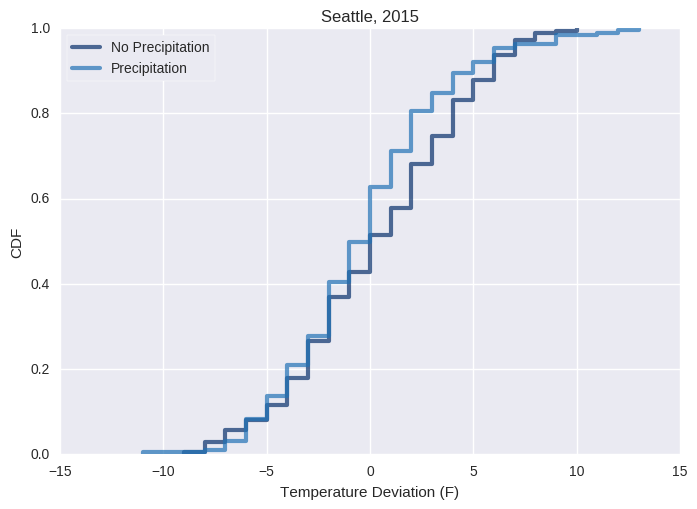

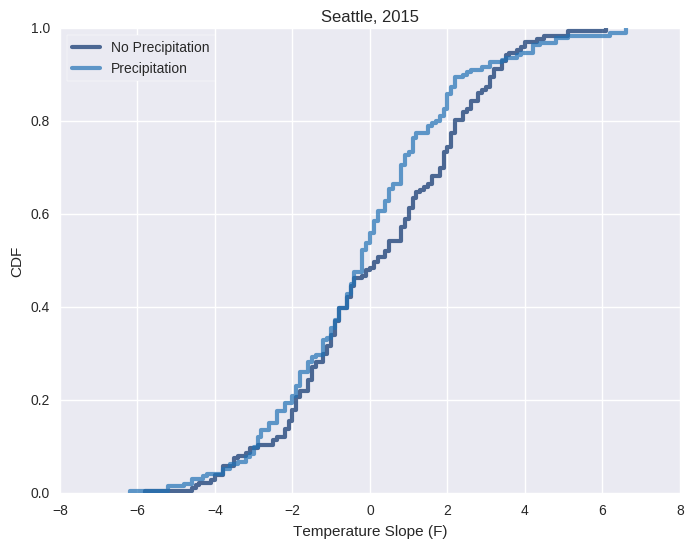

In [8]:
# Plots CDFs of all temperature deviation and temperature deviation when there is precipitation for comparison

seatac_2015_precip_true = seatac_2015[seatac_2015.BOOLPrecip == True].copy(deep=True)
seatac_2015_precip_false = seatac_2015[seatac_2015.BOOLPrecip == False].copy(deep=True)

print('Number of precipitation events: %i' %(seatac_2015_precip_true.shape[0]))
print('Number of days total: %i' %(seatac_2015.shape[0]))

noprecip_temp_dev_cdf = thinkstats2.Cdf(seatac_2015_precip_false['DEVFromAvg'].round(decimals=0), label='No Precipitation')
precip_temp_dev_cdf = thinkstats2.Cdf(seatac_2015_precip_true['DEVFromAvg'].round(decimals=0), label='Precipitation')

noprecip_temp_slp_cdf = thinkstats2.Cdf(seatac_2015_precip_false['SLOPETemp'].round(decimals=1), label='No Precipitation')
precip_temp_slp_cdf = thinkstats2.Cdf(seatac_2015_precip_true['SLOPETemp'].round(decimals=1), label='Precipitation')

thinkplot.Cdf(noprecip_temp_dev_cdf)
thinkplot.Cdf(precip_temp_dev_cdf)
thinkplot.Config(xlabel='Temperature Deviation (F)', ylabel='CDF', title='%s, 2015' %(selected_station), loc='best')
thinkplot.Show()

thinkplot.Cdf(noprecip_temp_slp_cdf)
thinkplot.Cdf(precip_temp_slp_cdf)
thinkplot.Config(xlabel='Temperature Slope (F)', ylabel='CDF', title='%s, 2015' %(selected_station), loc='best')
thinkplot.Show()

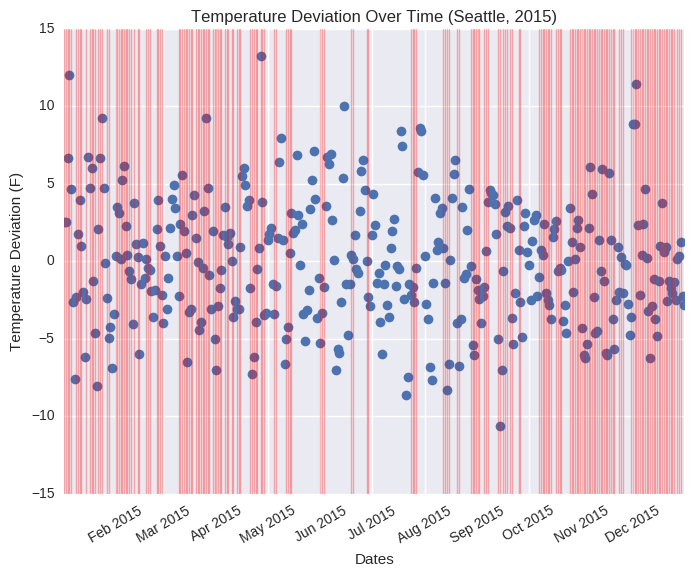

In [9]:
plot_date(seatac_2015.index.astype(datetime), seatac_2015.DEVFromAvg)

# Plots a red line on each date there is a precipitation event
for d in seatac_2015.index:
    if seatac_2015.ix[d].BOOLPrecip == True:
        plt.axvline(d, color='red', alpha=0.3, linewidth=1)

plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Temperature Deviation (F)')
plt.title('Temperature Deviation Over Time (%s, 2015)' %(selected_station))
plt.show()

This representation of the data is not clear enough to establish a relationship between temperature deviation and precipitation events. However, we can see if there is a relationship by running a logistical regression model on the data. We try using different combinations of explanatory variables to create models.

In [10]:
formula = 'seatac_2015.BOOLPrecipNum ~ seatac_2015.SLOPETemp + seatac_2015.ISRisingSlp'
model = smf.logit(formula, data=seatac_2015)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.688484
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     seatac_2015.BOOLPrecipNum   No. Observations:                  364
Model:                                 Logit   Df Residuals:                      361
Method:                                  MLE   Df Model:                            2
Date:                       Fri, 31 Mar 2017   Pseudo R-squ.:                0.004972
Time:                               20:34:59   Log-Likelihood:                -250.61
converged:                              True   LL-Null:                       -251.86
                                               LLR p-value:                    0.2859
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.1476      0.200      0.737      0.461        -0.245     0.540
seatac_2015.ISRisingSlp[T.True]    -0.1001      0.358     -0.279      0.780        -0.803     0.602
seatac_2015.SLOPETemp              -0.0534      0.078     -0.687      0.492        -0.206     0.099
===================================================================================================
"""

In [11]:
formula = 'seatac_2015.BOOLPrecipNum ~ seatac_2015.DEVFromAvg + seatac_2015.ISRisingAvg'
model = smf.logit(formula, data=seatac_2015)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.682944
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     seatac_2015.BOOLPrecipNum   No. Observations:                  364
Model:                                 Logit   Df Residuals:                      361
Method:                                  MLE   Df Model:                            2
Date:                       Fri, 31 Mar 2017   Pseudo R-squ.:                 0.01298
Time:                               20:34:59   Log-Likelihood:                -248.59
converged:                              True   LL-Null:                       -251.86
                                               LLR p-value:                   0.03806
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.2748      0.137      2.004      0.045         0.006     0.544
seatac_2015.ISRisingAvg[T.True]    -0.7633      0.380     -2.009      0.045        -1.508    -0.019
seatac_2015.DEVFromAvg              0.0188      0.040      0.472      0.637        -0.059     0.097
===================================================================================================
"""

In [12]:
formula = 'seatac_2015.BOOLPrecipNum ~ seatac_2015.ISRisingSlp + seatac_2015.ISRisingAvg'
model = smf.logit(formula, data=seatac_2015)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.683249
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Logit Regression Results                              
=====================================================================================
Dep. Variable:     seatac_2015.BOOLPrecipNum   No. Observations:                  364
Model:                                 Logit   Df Residuals:                      361
Method:                                  MLE   Df Model:                            2
Date:                       Fri, 31 Mar 2017   Pseudo R-squ.:                 0.01254
Time:                               20:34:59   Log-Likelihood:                -248.70
converged:                              True   LL-Null:                       -251.86
                                               LLR p-value:                   0.04253
===================================================================================================
                                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           0.2420      0.146      1.660      0.097        -0.044     0.528
seatac_2015.ISRisingSlp[T.True]     0.0064      0.259      0.025      0.980        -0.500     0.513
seatac_2015.ISRisingAvg[T.True]    -0.6341      0.308     -2.057      0.040        -1.238    -0.030
===================================================================================================
"""